In [1]:
import collections
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate

In [2]:
match_1 = json.load(open("../data/dataset/match_1.json"))
match_2 = json.load(open("../data/dataset/match_2.json"))
match = match_1 + match_2

In [3]:
# Basic exploration
tmp = dict(collections.Counter(list(map(lambda x: x["label"], match))))
action_amount = pd.DataFrame(columns=["action", "amount"], data=tmp.items()).set_index("action")
action_amount

,amount
action,
walk,435
rest,35
run,552
tackle,31
dribble,78
pass,32
cross,4
shot,18
no action,2


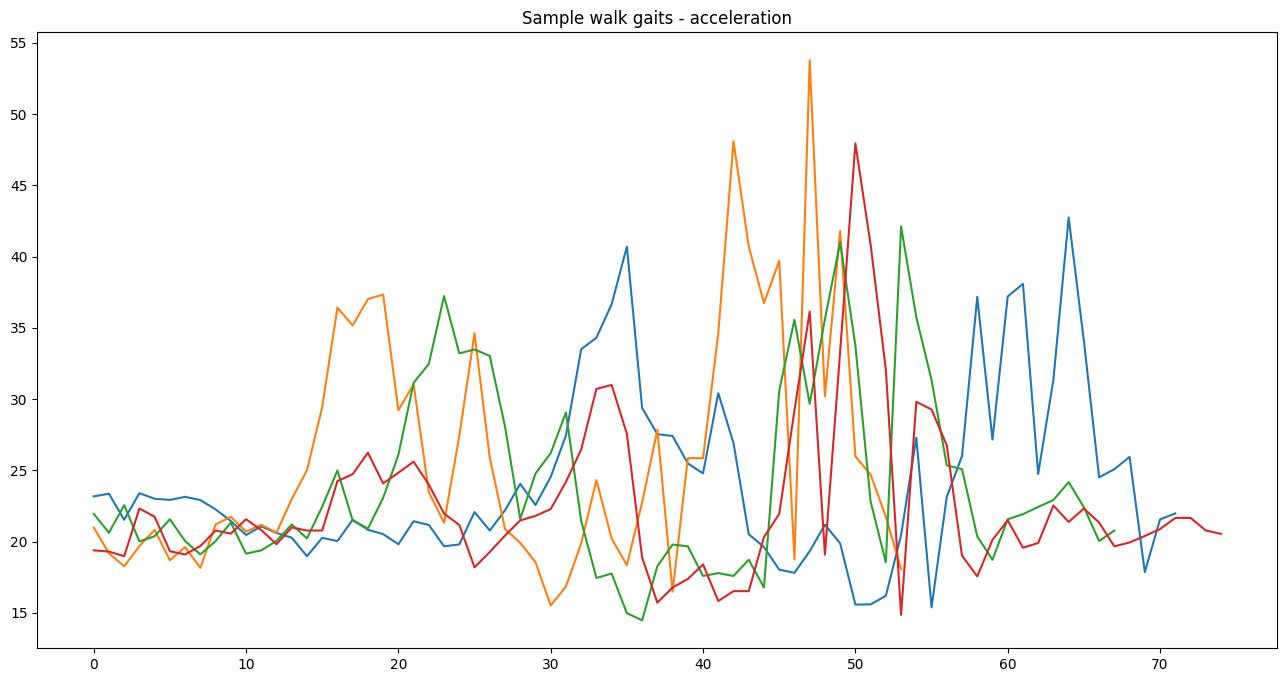

In [4]:
fig = plt.figure(figsize=(16, 8))
for action in match_1[:5]:
    if action["label"]=="walk":
        plt.plot(action["norm"])
plt.title("Sample walk gaits - acceleration")
plt.show()

In [5]:
tmp = dict()

def f1(a, x):
    a[x["label"]] = a.get(x["label"], 0) + len(x["norm"])

list(map(lambda x: f1(tmp, x), match))

action_duration = pd.DataFrame(columns=["action", "duration"], data=tmp.items()).set_index("action")
action_duration["duration_s"] = action_duration["duration"]/50# 50Hz in seconds
action_duration

,duration,duration_s
action,,
walk,24067,481.34
rest,4052,81.04
run,20787,415.74
tackle,1433,28.66
dribble,3062,61.24
pass,1366,27.32
cross,210,4.20
shot,608,12.16
no action,268,5.36


In [6]:
actions = action_amount.join(action_duration, on=["action"]).reset_index()
actions["average_length"] = actions["duration"]/actions["amount"]
actions

,action,amount,duration,duration_s,average_length
0,walk,435,24067,481.34,55.326437
1,rest,35,4052,81.04,115.771429
2,run,552,20787,415.74,37.657609
3,tackle,31,1433,28.66,46.225806
4,dribble,78,3062,61.24,39.256410
5,pass,32,1366,27.32,42.687500
6,cross,4,210,4.20,52.500000
7,shot,18,608,12.16,33.777778
8,no action,2,268,5.36,134.000000


In [7]:
#total duration (minutes)
actions["duration_s"].sum()/60

18.617666666666665

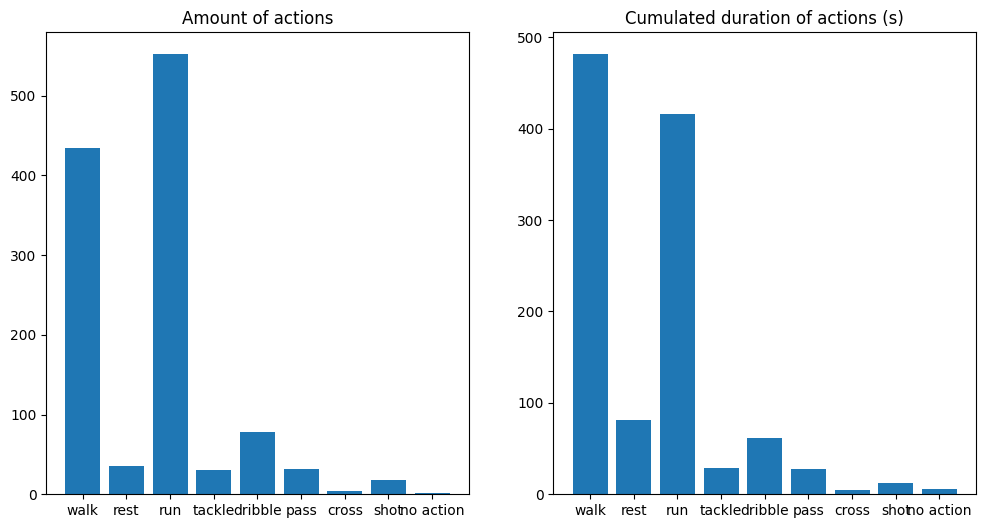

In [8]:
#amount of actions + total duration (in sec)
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].bar(actions["action"], actions["amount"])
axs[0].set_title("Amount of actions")
axs[1].bar(actions["action"], actions["duration_s"])
axs[1].set_title("Cumulated duration of actions (s)")
plt.show()

In [9]:
tmp = dict()

def f2(a, x):
    a[x["label"]] = a.get(x["label"], []) + [len(x["norm"])/50]

list(map(lambda x: f2(tmp, x), match))

action_length = pd.DataFrame(columns=["action", "length"], data=tmp.items())
action_length

,action,length
0,walk,"[1.44, 1.08, 1.36, 1.5, 1.12, 1.12, 1.12, 1.0,..."
1,rest,"[3.62, 1.36, 0.72, 0.8, 1.4, 1.48, 2.84, 1.48,..."
2,run,"[1.16, 0.48, 0.32, 0.44, 0.68, 0.56, 0.6, 0.84..."
3,tackle,"[0.56, 0.8, 0.52, 0.64, 0.96, 0.56, 0.88, 0.52..."
4,dribble,"[1.0, 1.34, 0.52, 0.68, 0.64, 0.68, 0.86, 0.8,..."
5,pass,"[0.46, 0.8, 0.44, 0.6, 0.68, 0.48, 0.64, 1.96,..."
6,cross,"[0.84, 1.44, 1.32, 0.6]"
7,shot,"[0.08, 0.92, 0.42, 0.38, 0.54, 1.0, 0.72, 0.8,..."
8,no action,"[1.52, 3.84]"


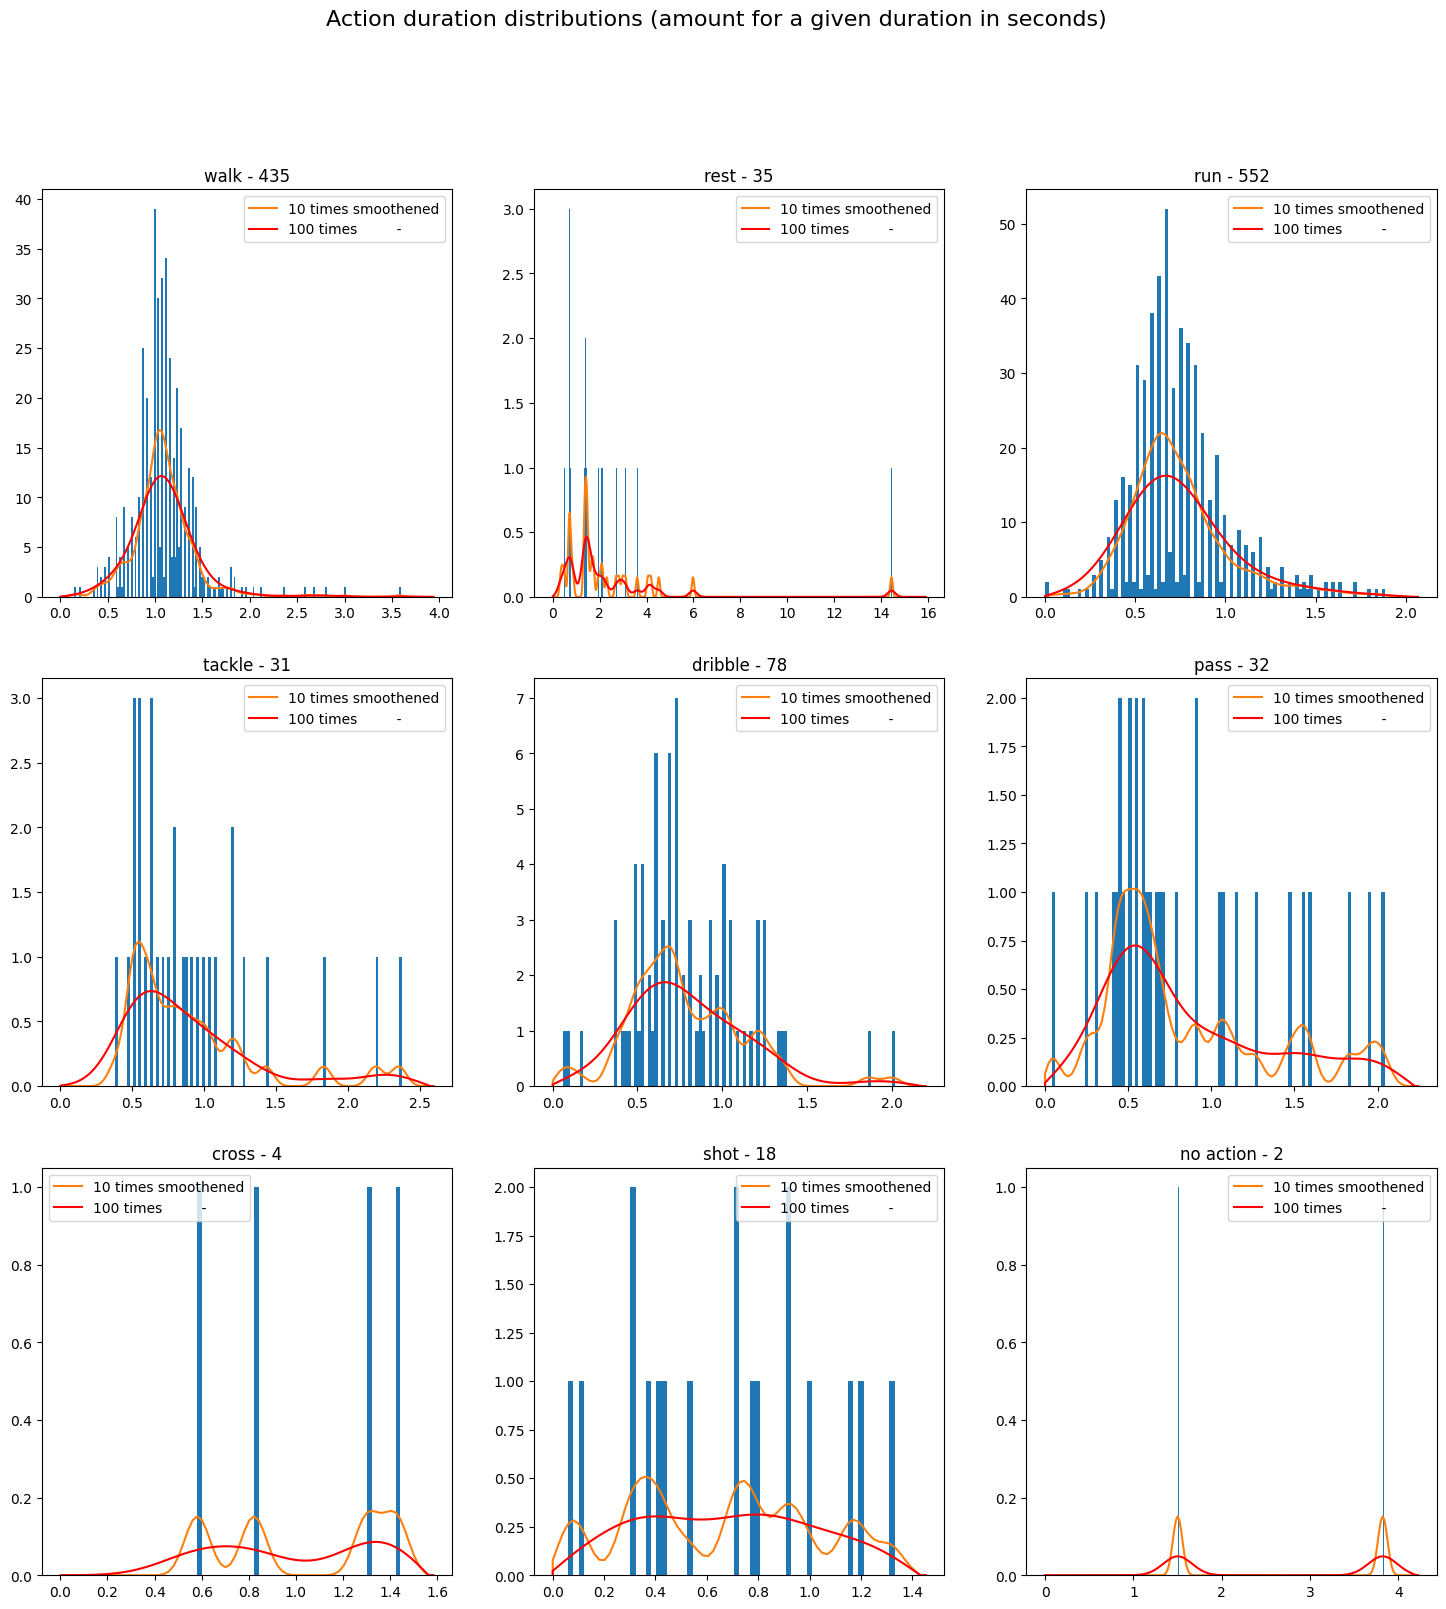

In [10]:
def smoothen(y, order=1):
    y_ = y
    for _ in range(order):
        y_ = np.concatenate((np.array([0]), [np.mean([y_[i-1], y_[i], y_[i+1]]) for i in range(1, len(y_)-1)], np.array([y_[-1]])))
    return y_

fig, axs = plt.subplots(3, 3, figsize=(18,18))
fig.suptitle("Action duration distributions (amount for a given duration in seconds)", fontsize=16)
for i, row in enumerate(action_length.iloc):
    y, x, _ = axs[i//3][i%3].hist(row["length"], range=(0, 1.1*max(row["length"])), bins=int(50*1.1*max(row["length"])))
    axs[i//3][i%3].set_title(f'{row["action"]} - {len(row["length"])}')
    x_ = np.insert(x, 0, 0., axis=0)
    y_ = np.insert(y, 0, 0., axis=0)
    y_ = smoothen(y_, 10)
    y_ = np.append(y_, 0.)
    axs[i//3][i%3].plot(x_, y_)
    x_ = np.insert(x, 0, 0., axis=0)
    y_ = np.insert(y, 0, 0., axis=0)
    y_ = smoothen(y_, 100)
    y_ = np.append(y_, 0.)
    axs[i//3][i%3].plot(x_, y_, color="r")
    axs[i//3][i%3].legend(["10 times smoothened", "100 times         -"])


plt.show()

In [11]:
tmp = dict()

def f3(a, x):
    a[x["label"]] = a.get(x["label"], []) + [len(x["norm"])]

list(map(lambda x: f3(tmp, x), match))

action_length_ = pd.DataFrame(columns=["action", "length"], data=tmp.items())
action_length_

,action,length
0,walk,"[72, 54, 68, 75, 56, 56, 56, 50, 50, 44, 38, 4..."
1,rest,"[181, 68, 36, 40, 70, 74, 142, 74, 69, 36, 22,..."
2,run,"[58, 24, 16, 22, 34, 28, 30, 42, 28, 30, 38, 1..."
3,tackle,"[28, 40, 26, 32, 48, 28, 44, 26, 60, 40, 30, 2..."
4,dribble,"[50, 67, 26, 34, 32, 34, 43, 40, 32, 34, 18, 3..."
5,pass,"[23, 40, 22, 30, 34, 24, 32, 98, 53, 46, 26, 2..."
6,cross,"[42, 72, 66, 30]"
7,shot,"[4, 46, 21, 19, 27, 50, 36, 40, 16, 36, 46, 39..."
8,no action,"[76, 192]"


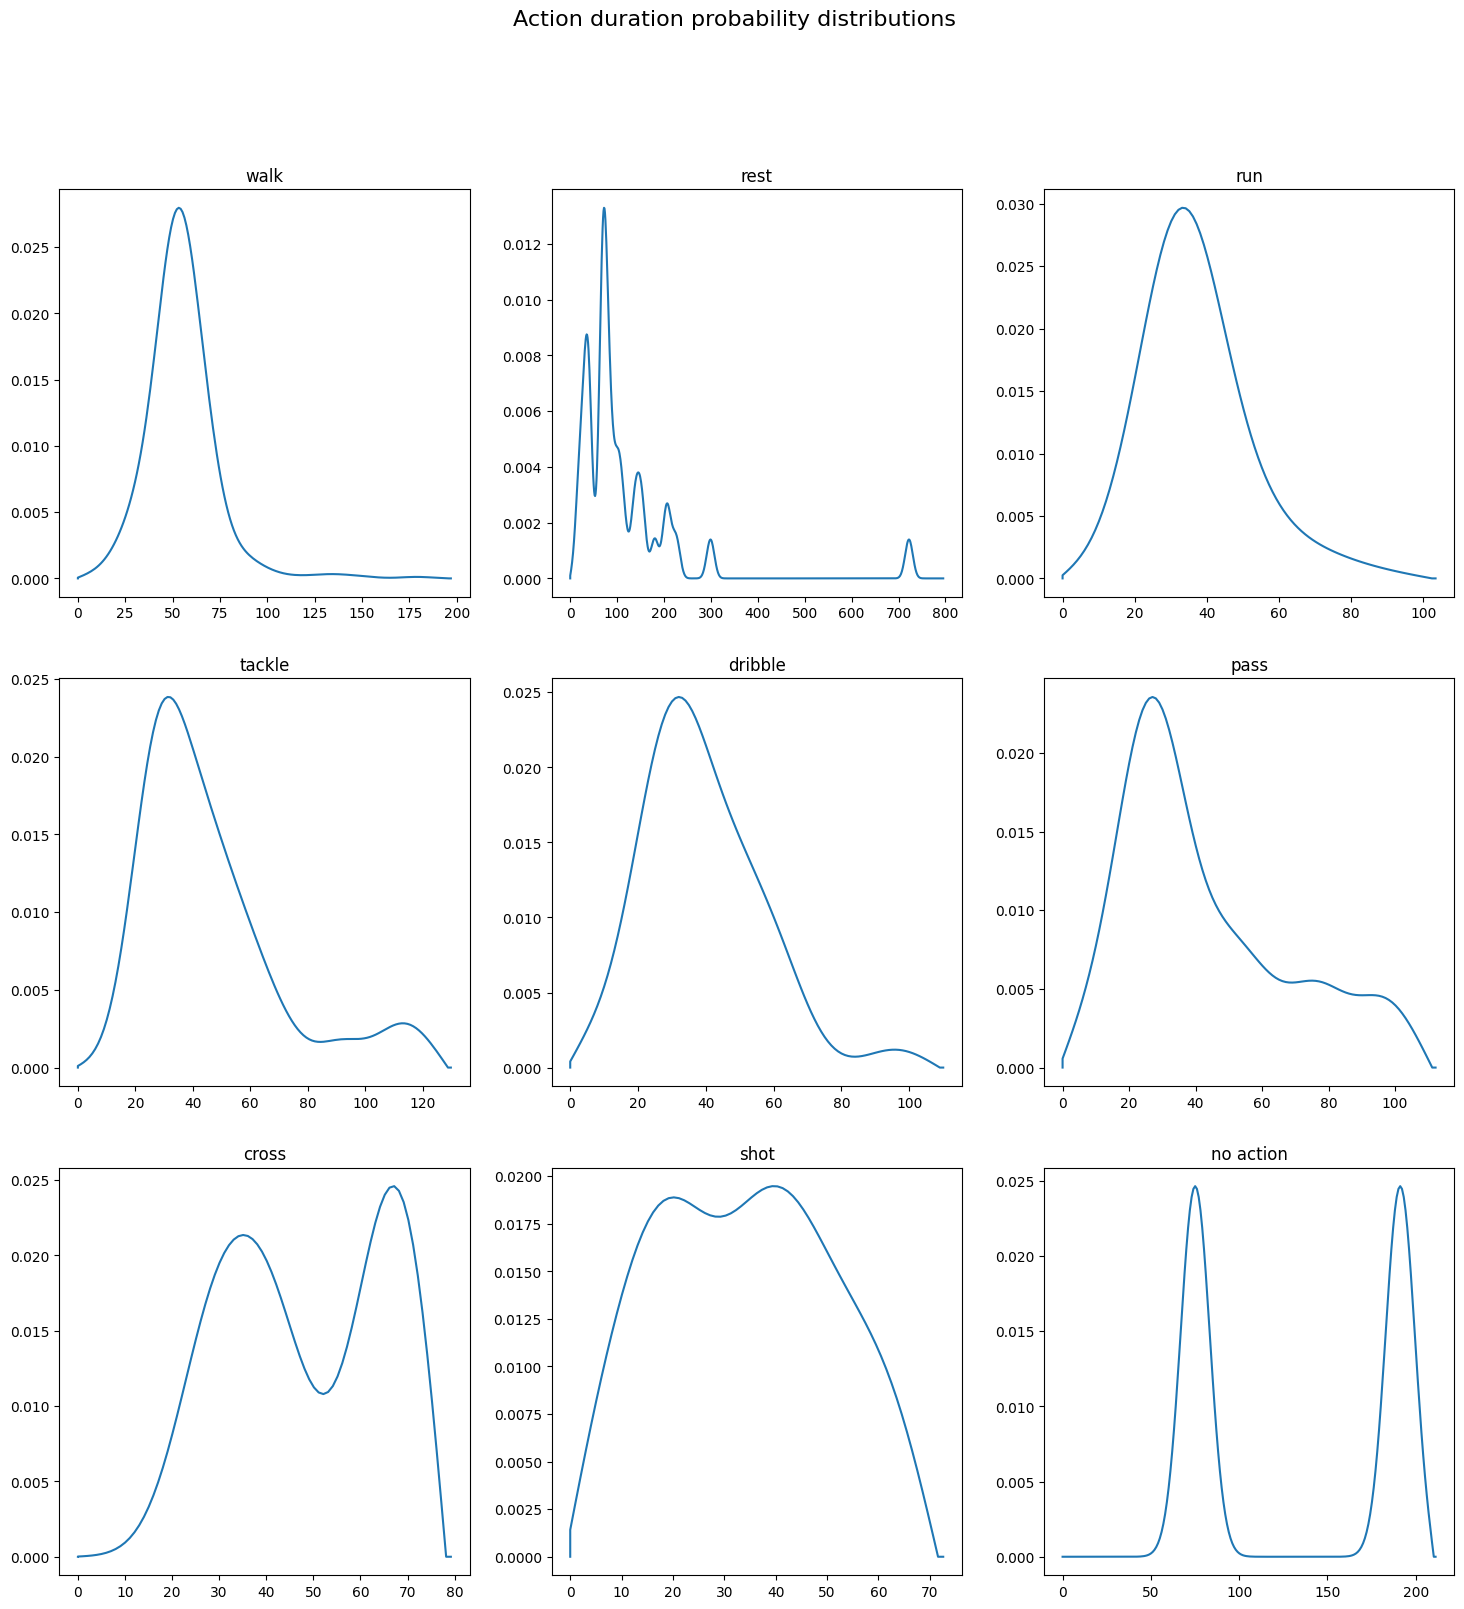

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(18,18))
fig.suptitle("Action duration probability distributions", fontsize=16)
for i, row in enumerate(action_length_.iloc):
    y, x, _ = axs[i//3][i%3].hist(row["length"], range=(0, 1.1*max(row["length"])), bins=int(1.1*max(row["length"])))
    axs[i//3][i%3].cla()
    axs[i//3][i%3].set_title(f'{row["action"]}')
    x_ = np.insert(x, 0, 0., axis=0)
    y_ = np.insert(y, 0, 0., axis=0)
    y_ = smoothen(y_, 100)
    y_ = np.append(y_, 0.)
    y_ = y_/np.sum(y_)
    axs[i//3][i%3].plot(x_, y_)
    np.save(f'../data/durations/durations_{row["action"].replace(" ", "_")}', x_)
    np.save(f'../data/distributions/distributions_{row["action"].replace(" ", "_")}', y_)

plt.show()

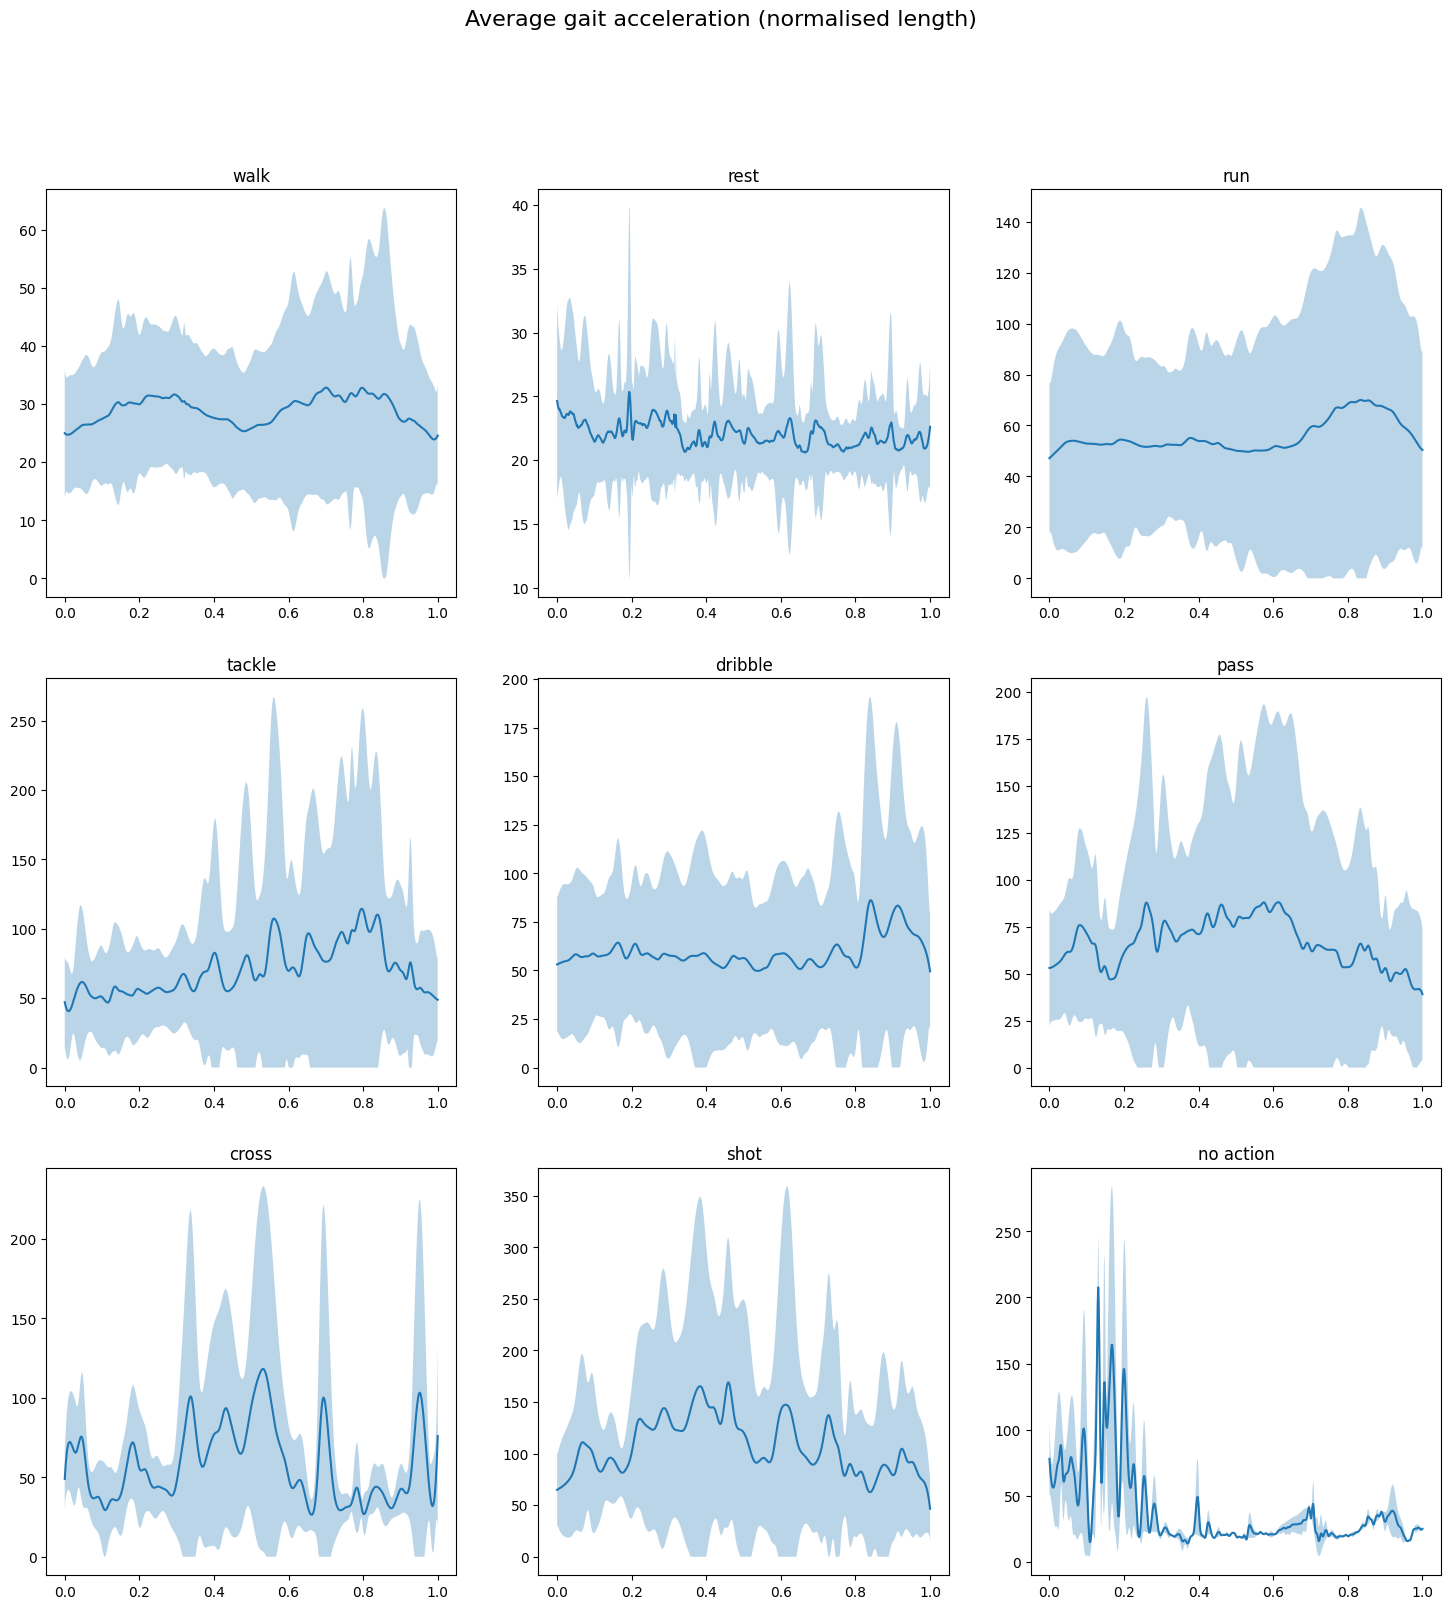

In [13]:
ys = {
    "no action": [],
    "run": [],
    "pass": [],
    "rest": [],
    "walk": [],
    "dribble": [],
    "shot": [],
    "tackle": [],
    "cross": [],
}
for action in match:
    if len(action["norm"]) < 5:
        continue
    tck = interpolate.splrep(np.linspace(0, len(action["norm"]), len(action["norm"])), action["norm"], s=0)
    x_ = np.linspace(0, len(action["norm"]), 720)
    y_ = interpolate.splev(x_, tck, der=0)
    ys[action["label"]].append(y_)

fig, axs = plt.subplots(3, 3, figsize=(18,18))
fig.suptitle("Average gait acceleration (normalised length)", fontsize=16)
for i, row in enumerate(action_length_.iloc):
    action = row["action"]
    y_ = np.mean(ys[action], axis=0)
    y_std = np.std(ys[action], axis=0)
    y_sup = y_+y_std
    y_inf = np.clip(y_-y_std, 0, np.max(y_))# Acceleration norm > 0
    x_ = np.linspace(0, 1, 720)
    axs[i//3][i%3].plot(x_, y_)
    axs[i//3][i%3].fill_between(x_, y_sup, y_inf, alpha=0.3)
    axs[i//3][i%3].set_title(f'{action}')
    np.save(f'../data/y_infs/y_inf_{action.replace(" ", "_")}', y_inf)
    np.save(f'../data/y_sups/y_sup_{action.replace(" ", "_")}', y_sup)

plt.show()